# RNNによる画像生成
画像を時系列のデータと捉えることで、RNNにより画像を生成することが可能になります。  
今回は、画像データを使ってRNNを訓練し、画像の上半分をもとに画像の下半分を生成します。  
RNNの層にはLSTMを使用します。  


## Fashion-MNIST
torchvision.datasetsを使い、Fashion-MNISTを読み込みます。  
Fashion-MNISTは、6万枚のファッションアイテム画像にラベルをつけたたデータセットです。  
以下のコードでは、Fashion-MNISTを読み込み、ランダムな25枚の画像を表示します。

## 練習問題
１枚目の画像の中身の数値を確認してください

## 参考

https://github.com/zalandoresearch/fashion-mnist


データの数: 60000
データ
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 3 5 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 4 5 2 5 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 4 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 1 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 6 5 5 5 3 7 5 4 5 5 4 7 5 4 4 4 4 0 0 0 0 0]
 [0 0 0 0 0 0 5 6 5 6 5 8 6 5 5 5 6 8 5 4 4 4 4 0 0 0 0 0]
 [0 0 0 0 0 0 5 5 5 6 4 8 5 5 4 5 5 8 5 4 4 4 4 0 0 0 0 0]
 [0 0 0 0 0 0 5 5 5 5 4 8 4 5 4 4 4 8 5 4 3 4 4 0 0 0 0 0]
 [0 0 0 0 0 0 5 5 5 5 5 9 4 4 3 3 4 7 5 5 3 3 5 0 0 0 0 0]
 [0 0 0 0 0 0 5 4 5 4 6 9 3 4 4 4 3 8 6 4 4 3 4 0 0 0 0 0]
 [0 0 0 0 0 0 5 5 5 4 6 6 4 5 4 5 4 6 

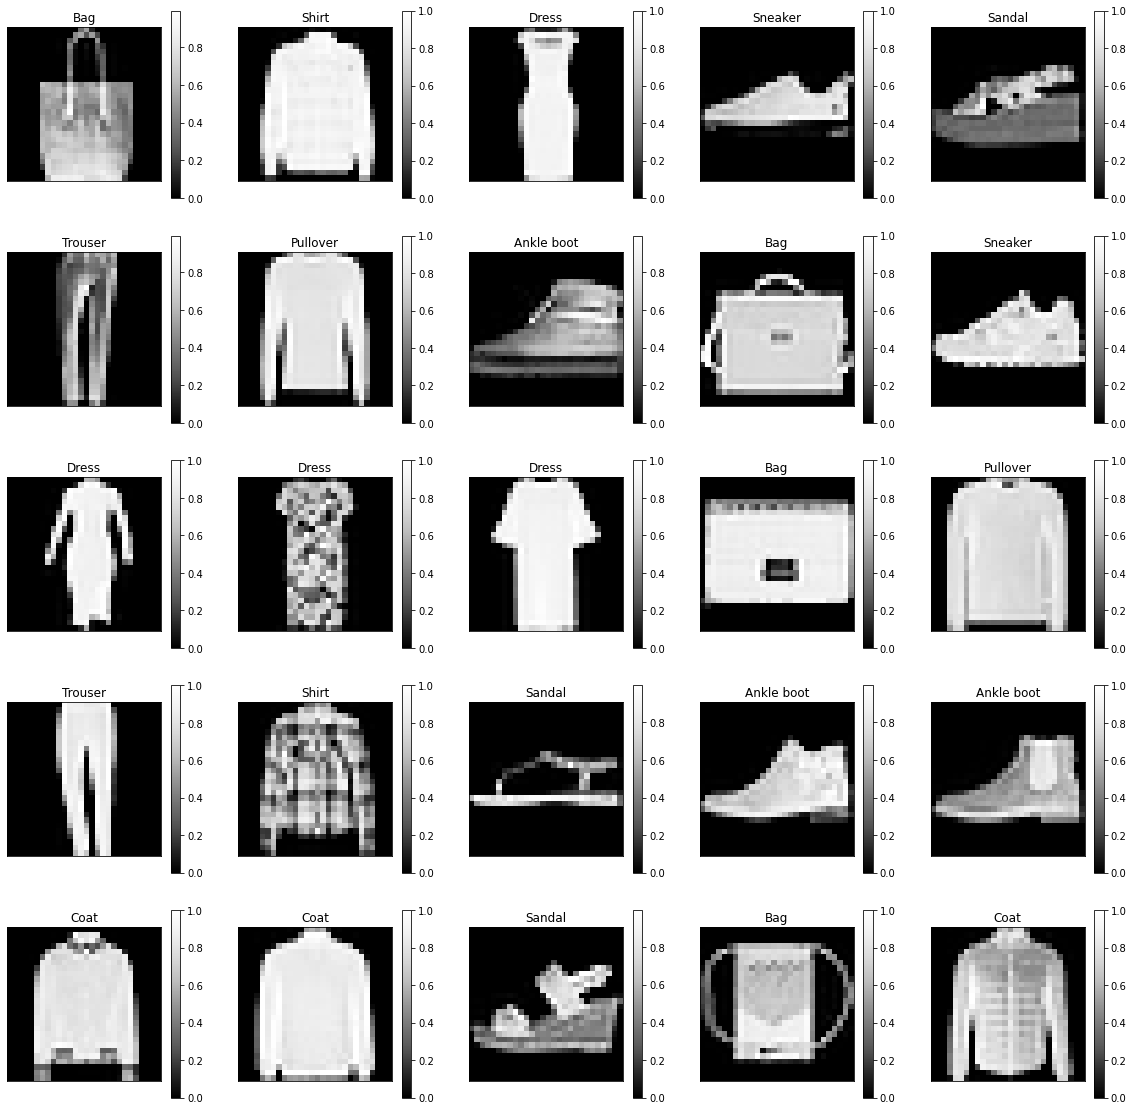

In [7]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

fmnist_data = FashionMNIST(root="./data",
                            train=True,download=True,
                            transform=transforms.ToTensor())
fmnist_classes = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
print("データの数:", len(fmnist_data))

n_image = 25  # 表示する画像の数
fmnist_loader = DataLoader(fmnist_data, batch_size=n_image, shuffle=True)
dataiter = iter(fmnist_loader)  # イテレータ
images, labels = dataiter.next()  # 最初のバッチを取り出す

img_size = 28

# 画像の中身確認
np.set_printoptions(precision=0, floatmode='fixed', linewidth=500)
img = images[0].reshape(img_size, img_size).numpy()
print("データ\n" , (img * 10).astype(np.int))

plt.figure(figsize=(20,20))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i].reshape(img_size, img_size), cmap="Greys_r")
    label = fmnist_classes[labels[i]]
    plt.title(label)
    plt.colorbar() # colorバーを追加
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

## データの前処理
画像データをRNNに適した形に整えます。  
画像を時系列データに変換しますが、正解は時系列の次の行にします。 

In [12]:
import torch
from torch.utils.data import DataLoader

n_time = 14  # 時系列の数
n_in = img_size  # 入力層のニューロン数
n_mid = 256  # 中間層のニューロン数
n_out = img_size  # 出力層のニューロン数
n_sample_in_img = img_size - n_time  # 1枚の画像中のサンプル数

dataloader = DataLoader(fmnist_data, batch_size=len(fmnist_data), shuffle=False)
dataiter = iter(dataloader)  # イテレータ
train_imgs, labels = dataiter.next()  # データを取り出す

print("labels ->", labels.shape)                # torch.Size([60000])
print("train_imgs.shape ->" , train_imgs.shape) # torch.Size([60000, 1, 28, 28])

train_imgs = train_imgs.reshape(-1, img_size, img_size)
print("train_imgs.shape ->" , train_imgs.shape) # torch.Size([60000, 28, 28])

n_sample = len(train_imgs) * n_sample_in_img  # サンプル数 60000 × (28 - 14)

input_data = np.zeros((n_sample, n_time, n_in))  # 入力 torch.Size([840000, 14, 28])
correct_data = np.zeros((n_sample, n_out))       # 正解 torch.Size([840000, 28])
for i in range(len(train_imgs)):                 # 60000枚
    for j in range(n_sample_in_img):             # 14 (1枚の画像中のサンプル数)
        sample_id = i * n_sample_in_img + j
        input_data[sample_id] = train_imgs[i , j : j + n_time]
        correct_data[sample_id] = train_imgs[i , j + n_time]

input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)

print("input_data.shape ->", input_data.shape)       # torch.Size([840000, 14, 28])
print("correct_data.shape ->", correct_data.shape)   # torch.Size([840000, 28])

dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)  # DataLoaderの設定

labels -> torch.Size([60000])
train_imgs.shape -> torch.Size([60000, 1, 28, 28])
train_imgs.shape -> torch.Size([60000, 28, 28])
input_data.shape -> torch.Size([840000, 14, 28])
correct_data.shape -> torch.Size([840000, 28])


## テスト用のデータ
今回は、訓練済みのモデルが機能することを確かめるために使用します。

In [14]:
n_disp = 10  # 生成し表示する画像の数

disp_data = FashionMNIST(root="./data",
                            train=False,download=True,
                            transform=transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size=n_disp, shuffle=False)
dataiter = iter(disp_loader)  # イテレータ
disp_imgs, labels = dataiter.next()  # データを取り出す
disp_imgs = disp_imgs.reshape(-1, img_size, img_size)

## 画像生成用の関数
以下の関数は、オリジナルの画像`disp_imgs`と、この画像の上半分をもとに下半分を生成した`gen_imgs`を並べて表示します。  
最初は画像の上半分をシードにして新たな行を生成しますが、次はその新たな行を含む直近の時系列からさらに次の行を生成します。  
これを繰り返すことで、下半分の画像が生成されます。  

In [15]:
def generate_images():
    # オリジナルの画像
    print("Original:")
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
        ax = plt.subplot(1, n_disp, i+1)
        plt.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 軸を非表示に
        ax.get_yaxis().set_visible(False)
    plt.show()

    # 下半分をRNNにより生成した画像
    print("Generated:")
    gen_imgs = disp_imgs.clone()
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
        for j in range(n_sample_in_img):
            x = gen_imgs[i, j:j+n_time].reshape(1, n_time, img_size)
            x = x.cuda()  # GPU対応
            gen_imgs[i, j+n_time] = net(x)[0]
        ax = plt.subplot(1, n_disp, i+1)
        plt.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 軸を非表示に
        ax.get_yaxis().set_visible(False)
    plt.show()

## モデルの構築
`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
LSTMは`nn.LSTM`を使って実装することができます。

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(  # LSTM層
            input_size=n_in,  # 入力サイズ
            hidden_size=n_mid,  # ニューロン数
            batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする
        )
        self.fc = nn.Linear(n_mid, n_out)  # 全結合層 Fully Connected層

    def forward(self, x):
        y_rnn, (h, c) = self.rnn(x, None)  # hは次の時刻に渡される値、 cは記憶セル
        y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
        return y

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (rnn): LSTM(28, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=28, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  
学習中、一定のエポック間隔ごとに誤差の表示と画像の生成が行われます。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。

Epoch: 0 Loss_Train: 0.017400332442870068
Original:


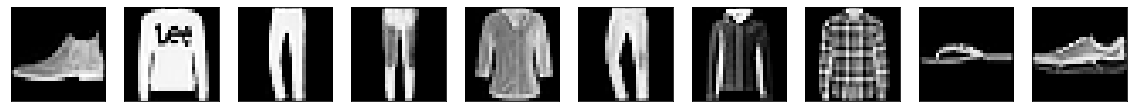

Generated:


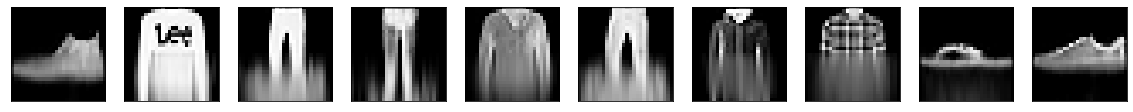

Epoch: 1 Loss_Train: 0.01352438394344393
Original:


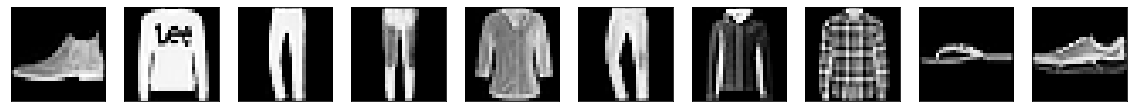

Generated:


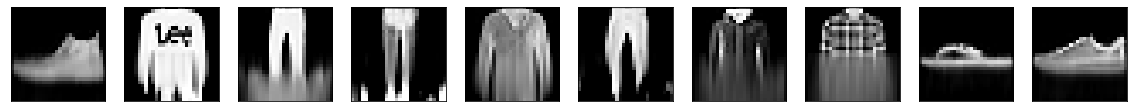

Epoch: 2 Loss_Train: 0.01242446929065114
Original:


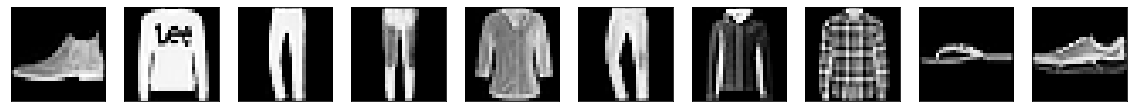

Generated:


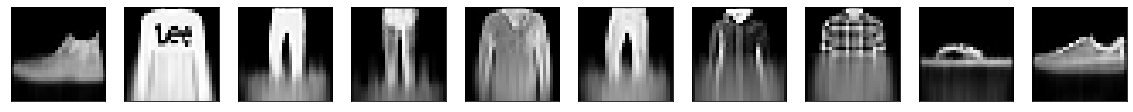

Epoch: 3 Loss_Train: 0.01185645995105065
Original:


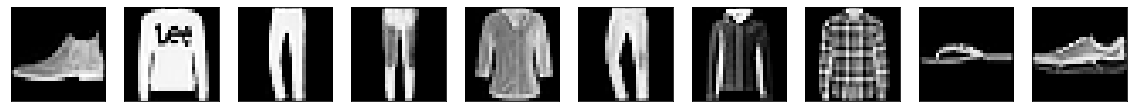

Generated:


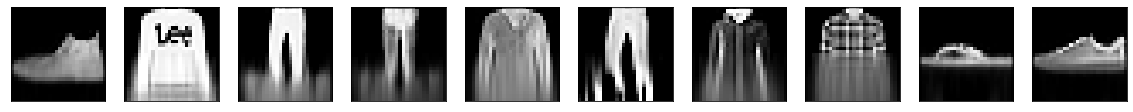

Epoch: 4 Loss_Train: 0.011467202695839547
Original:


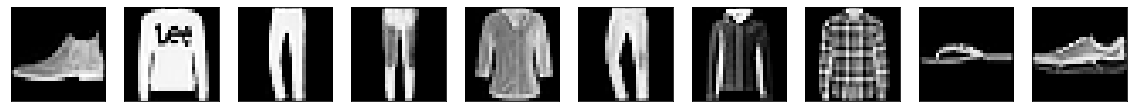

Generated:


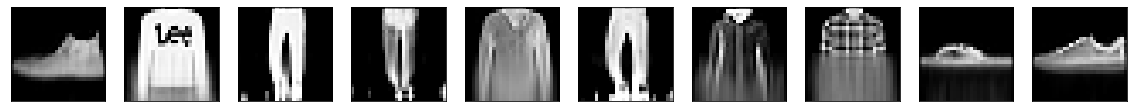

Epoch: 5 Loss_Train: 0.011161147768429148
Original:


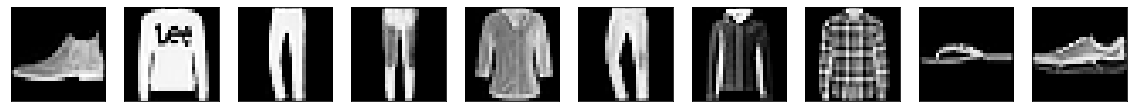

Generated:


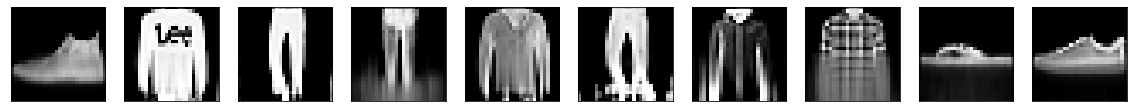

Epoch: 6 Loss_Train: 0.010914056235718601
Original:


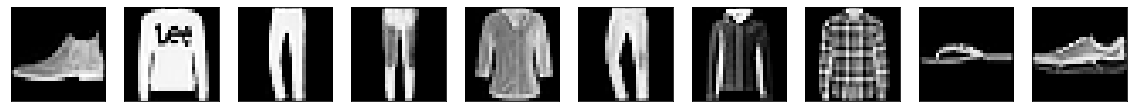

Generated:


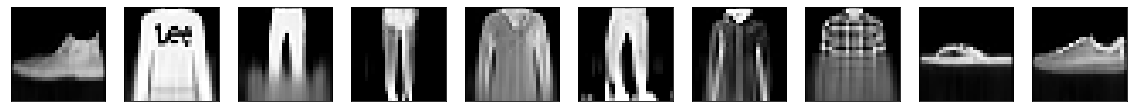

Epoch: 7 Loss_Train: 0.01069463421148592
Original:


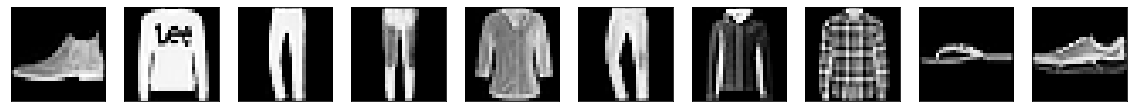

Generated:


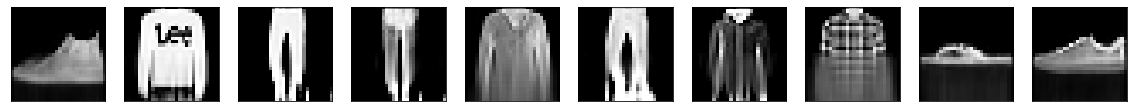

Epoch: 8 Loss_Train: 0.01049889297992713
Original:


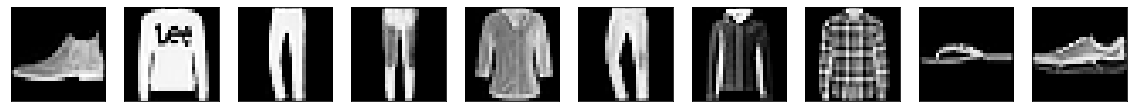

Generated:


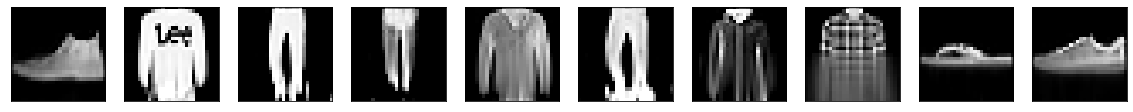

Epoch: 9 Loss_Train: 0.010329537868795487
Original:


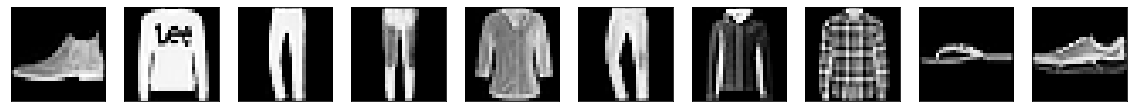

Generated:


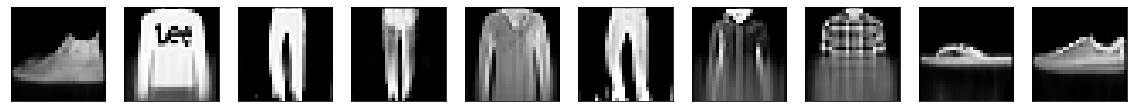

Epoch: 10 Loss_Train: 0.010176658035292439
Original:


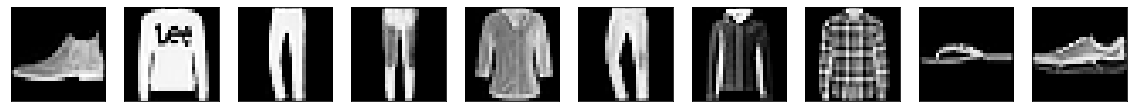

Generated:


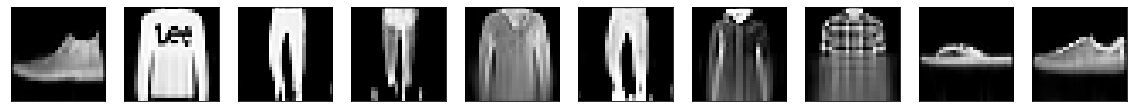

Epoch: 11 Loss_Train: 0.010038434391443675
Original:


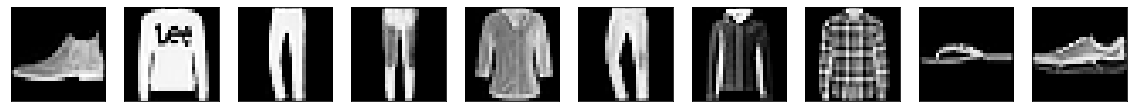

Generated:


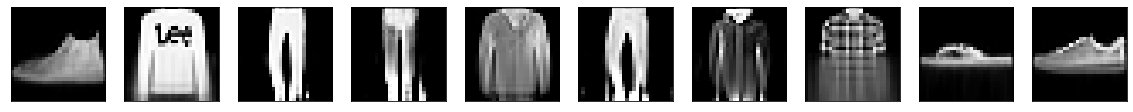

Epoch: 12 Loss_Train: 0.00990328184281719
Original:


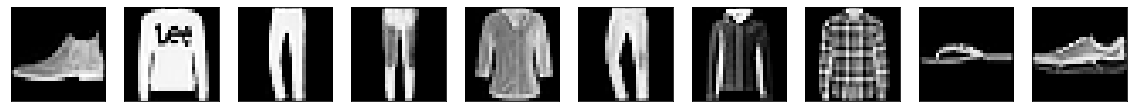

Generated:


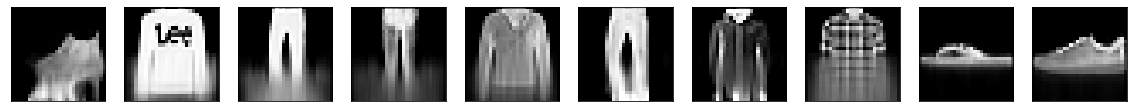

Epoch: 13 Loss_Train: 0.009784790135039668
Original:


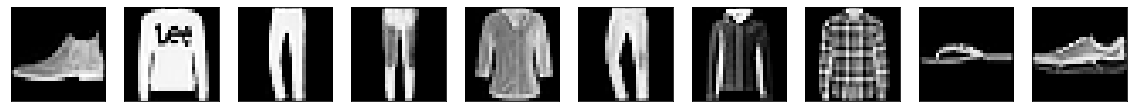

Generated:


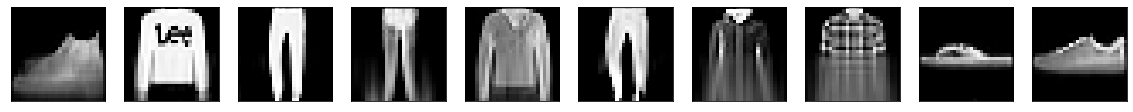

Epoch: 14 Loss_Train: 0.009676983432412039
Original:


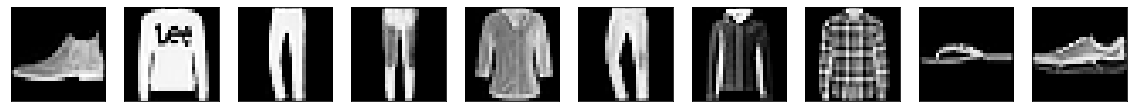

Generated:


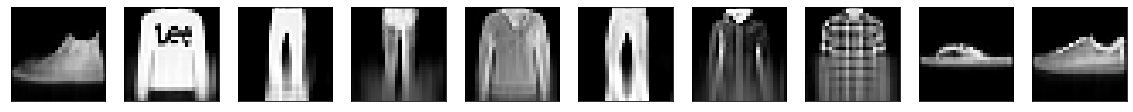

Epoch: 15 Loss_Train: 0.009579446328099765
Original:


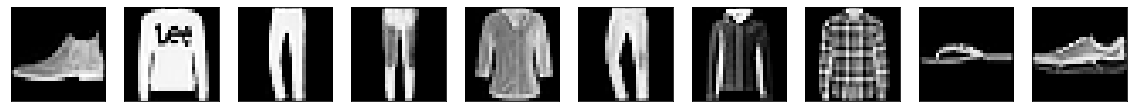

Generated:


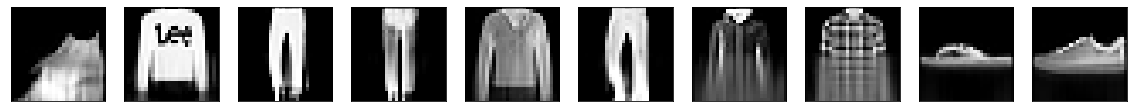

Epoch: 16 Loss_Train: 0.009480534737900469
Original:


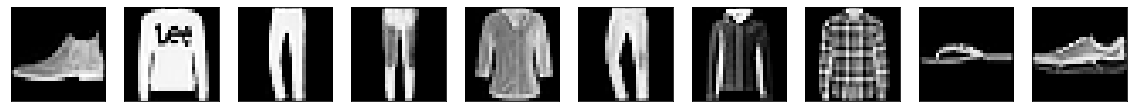

Generated:


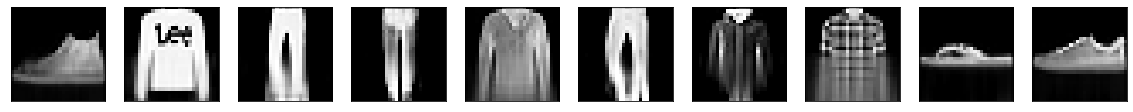

Epoch: 17 Loss_Train: 0.0093972960104716
Original:


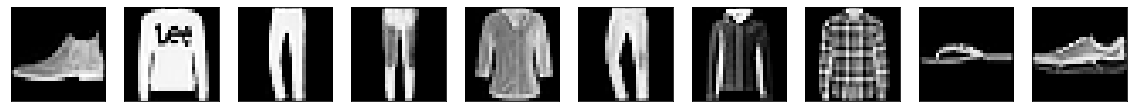

Generated:


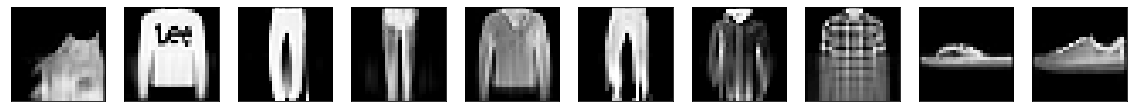

Epoch: 18 Loss_Train: 0.009315630488376369
Original:


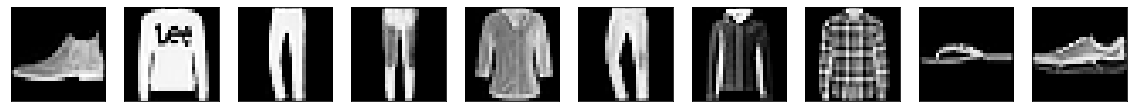

Generated:


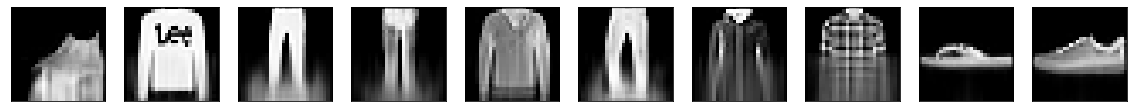

Epoch: 19 Loss_Train: 0.009240693846170007
Original:


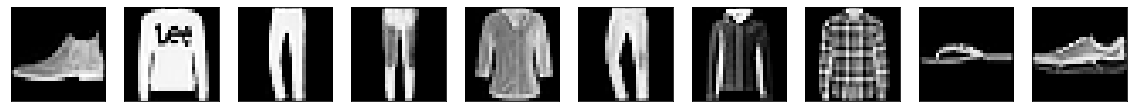

Generated:


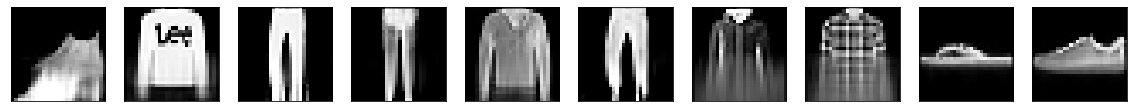

Epoch: 20 Loss_Train: 0.009163158771196108
Original:


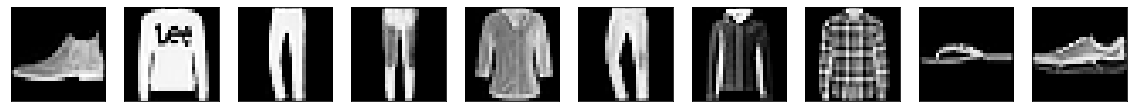

Generated:


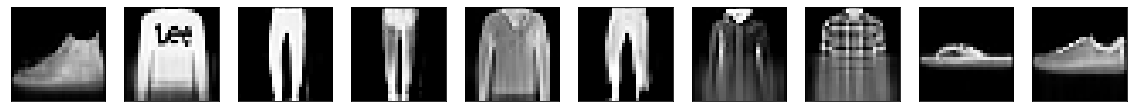

Epoch: 21 Loss_Train: 0.009093241501868035
Original:


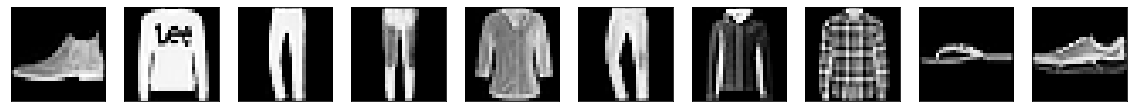

Generated:


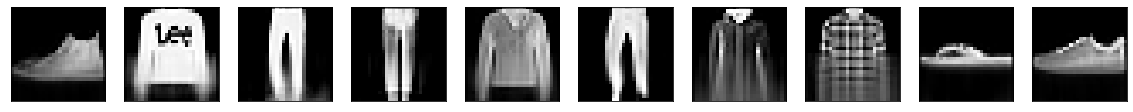

Epoch: 22 Loss_Train: 0.009023893709048577
Original:


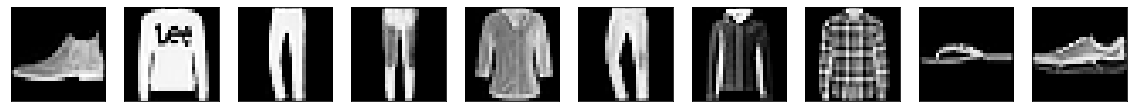

Generated:


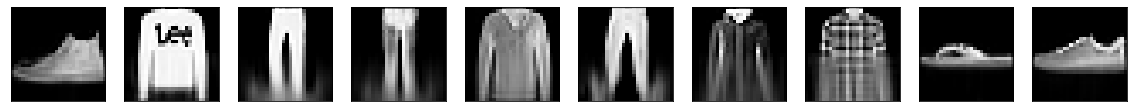

Epoch: 23 Loss_Train: 0.008966514011429212
Original:


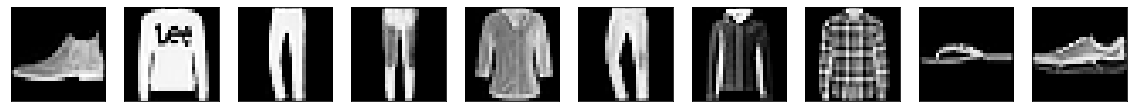

Generated:


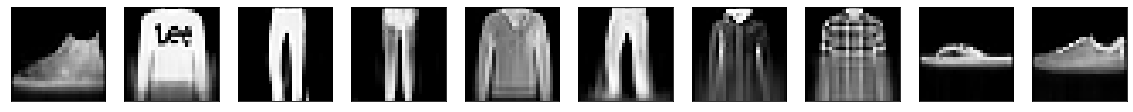

Epoch: 24 Loss_Train: 0.008916436109842845
Original:


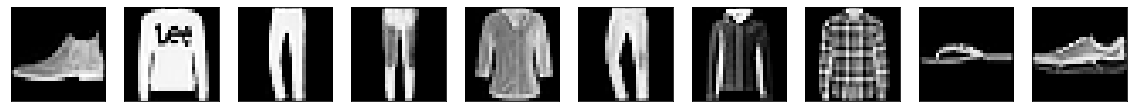

Generated:


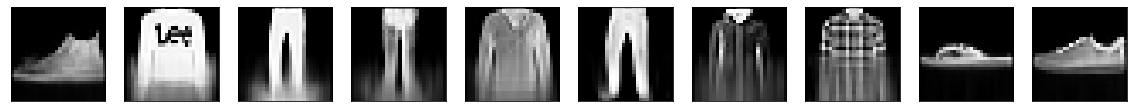

In [17]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.MSELoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())  # 学習率は0.01

# 損失のログ
record_loss_train = []

# 学習
for i in range(25):  # 25エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)
        generate_images()

## 誤差の推移
誤差の推移をグラフ表示します。  

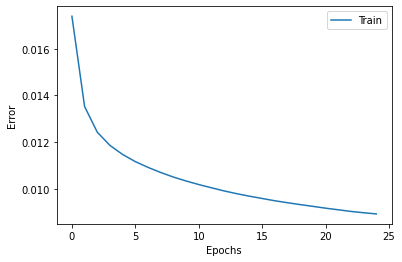

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

滑らかに誤差が減少していることが確認できます。